In this notebook, we will 
- Make a gradient boosting regressor (GBR) model with 59 Rdkit descriptors
- Predict the ERed of molecules in the test dataset
- save the model with pickle package

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

# import custom functions from the python file
import sys
sys.path.append('../') # path of the directory that contains Chemfunctions.py
import Chemfunctions as chemfun


# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# RDKit 
import rdkit.Chem as Chem

Get train and test data from the Data directory
- train and test data features are already scaled using 0_Features_split.ipynb

In [2]:
X_train = pd.read_csv(r'./Data/X_train_70pc_scaled.csv')
X_test = pd.read_csv(r'./Data/X_test_30pc_scaled.csv')
y_train = pd.read_csv(r'./Data/y_train_70pc_target.csv')
y_test = pd.read_csv(r'./Data/y_test_30pc_target.csv')

print(f'X_train.shape={X_train.shape}, y_train.shape={y_train.shape}')
print(f'X_test.shape={X_test.shape}, y_test.shape={y_test.shape}')

X_train.shape=(3809, 59), y_train.shape=(3809, 1)
X_test.shape=(1633, 59), y_test.shape=(1633, 1)


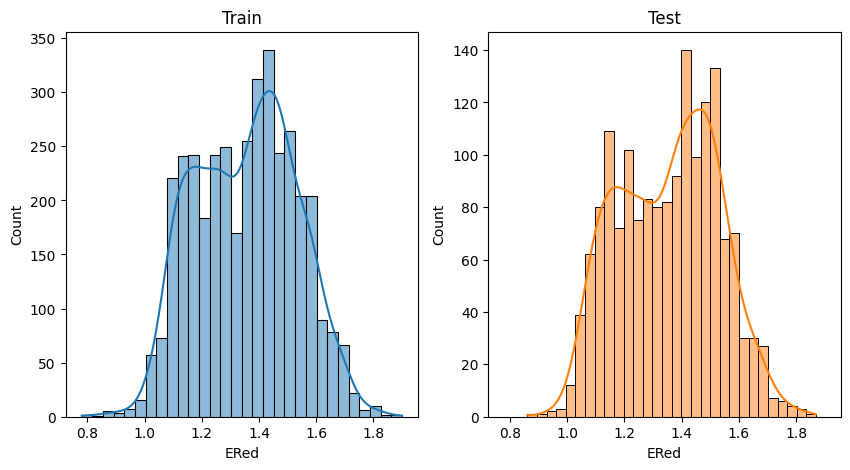

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
sns.histplot(ax=axs[0],x=y_train["ERed"], bins=30, kde=True,color="tab:blue")
sns.histplot(ax=axs[1],x=y_test["ERed"], bins=30, kde=True,color="tab:orange")
axs[0].set_xlabel("ERed")
axs[1].set_xlabel("ERed")
axs[0].set_ylabel("Count")
axs[1].set_ylabel("Count")
axs[0].set_title("Train")
axs[1].set_title("Test")
plt.show()

# GBR model

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.ensemble import GradientBoostingRegressor

In [5]:

gbr = GradientBoostingRegressor(learning_rate=0.01,max_depth=3,n_estimators=100)
pipe = Pipeline([("gbr", gbr)])
param_grid = {
    "gbr__learning_rate": np.logspace(-2, 0, 2),
    'gbr__max_depth':range(1,3),
    'gbr__n_estimators':range(100,300,100)
}
# search = GridSearchCV(pipe, param_grid, n_jobs=-1,return_train_score=True,scoring='r2',cv=RepeatedKFold(n_splits=5, n_repeats=3,random_state=11))
search = GridSearchCV(pipe, param_grid, n_jobs=-1,return_train_score=True,scoring='neg_mean_squared_error',cv=RepeatedKFold(n_splits=5, n_repeats=3,random_state=11))
search.fit(X_train,y_train["ERed"])

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=11),
             estimator=Pipeline(steps=[('gbr',
                                        GradientBoostingRegressor(learning_rate=0.01))]),
             n_jobs=-1,
             param_grid={'gbr__learning_rate': array([0.01, 1.  ]),
                         'gbr__max_depth': range(1, 3),
                         'gbr__n_estimators': range(100, 300, 100)},
             return_train_score=True, scoring='neg_mean_squared_error')

best model and score

In [6]:
search.best_params_, search.best_score_

({'gbr__learning_rate': 1.0, 'gbr__max_depth': 1, 'gbr__n_estimators': 200},
 -0.006376619017148129)

In [7]:
model=search.best_estimator_

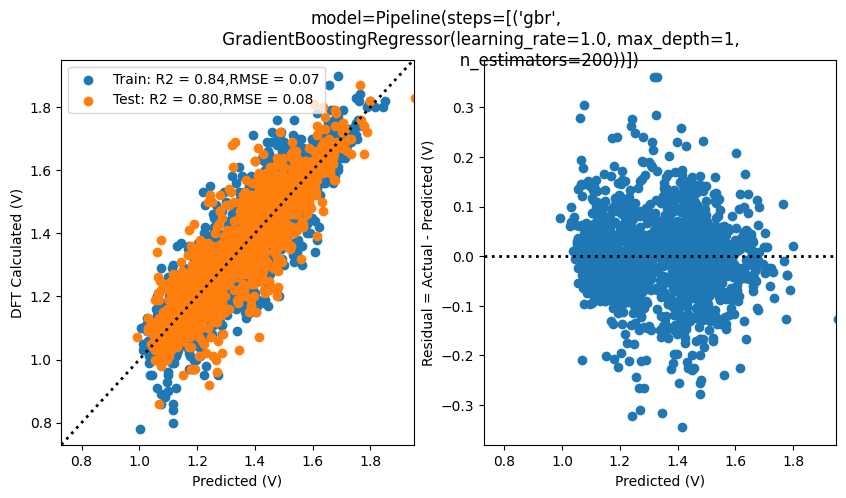

In [8]:
chemfun.pairity_plot(model=model,X_train=X_train,X_test=X_test,y_train=y_train["ERed"],y_test=y_test["ERed"])

Save model

In [9]:
import pickle

pickle.dump(model, open(r'./Models/GBRegression.sav', 'wb'))